# Advanced Linear Regession Assignment - Surprise Housing

It is required to model the price of houses with the available independent variables. This model will then be used by the management to understand how exactly the prices vary with the variables. They can accordingly manipulate the strategy of the firm and concentrate on areas that will yield high returns. Further, the model will be a good way for management to understand the pricing dynamics of a new market.

###### Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import calendar

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

### Reading the data

In [2]:
data = pd.read_csv('train.csv')
print(data.shape)
data.head()

(1460, 81)


Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

### Missing Data treatment

In [3]:
def check_missing_data():
    missing_data = [i for i in data.isna().mean().items() if i[1] > 0]
    missing_data.sort(key=lambda e:e[1], reverse=True)
    print(missing_data)
    
check_missing_data()

[('PoolQC', 0.9952054794520548), ('MiscFeature', 0.963013698630137), ('Alley', 0.9376712328767123), ('Fence', 0.8075342465753425), ('MasVnrType', 0.5972602739726027), ('FireplaceQu', 0.4726027397260274), ('LotFrontage', 0.1773972602739726), ('GarageType', 0.05547945205479452), ('GarageYrBlt', 0.05547945205479452), ('GarageFinish', 0.05547945205479452), ('GarageQual', 0.05547945205479452), ('GarageCond', 0.05547945205479452), ('BsmtExposure', 0.026027397260273973), ('BsmtFinType2', 0.026027397260273973), ('BsmtQual', 0.025342465753424658), ('BsmtCond', 0.025342465753424658), ('BsmtFinType1', 0.025342465753424658), ('MasVnrArea', 0.005479452054794521), ('Electrical', 0.0006849315068493151)]


There are lot of columns with missing values. We will drop the columns with >40% null values

In [4]:
data.drop(columns=[i[0] for i in data.isna().mean().items() if i[1] > 0.4], axis=1, inplace=True)
data.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street LotShape LandContour  \
0   1          60       RL         65.0     8450   Pave      Reg         Lvl   
1   2          20       RL         80.0     9600   Pave      Reg         Lvl   
2   3          60       RL         68.0    11250   Pave      IR1         Lvl   
3   4          70       RL         60.0     9550   Pave      IR1         Lvl   
4   5          60       RL         84.0    14260   Pave      IR1         Lvl   

  Utilities LotConfig  ... EnclosedPorch 3SsnPorch ScreenPorch PoolArea  \
0    AllPub    Inside  ...             0         0           0        0   
1    AllPub       FR2  ...             0         0           0        0   
2    AllPub    Inside  ...             0         0           0        0   
3    AllPub    Corner  ...           272         0           0        0   
4    AllPub       FR2  ...             0         0           0        0   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
0       0      2    2008        WD         Normal     208500  
1       0      5    2007        WD         Normal     181500  
2       0      9    2008        WD         Normal     223500  
3       0      2    2006        WD        Abnorml     140000  
4       0     12    2008        WD         Normal     250000  

[5 rows x 75 columns]

###### Missing data check again

In [5]:
check_missing_data()

[('LotFrontage', 0.1773972602739726), ('GarageType', 0.05547945205479452), ('GarageYrBlt', 0.05547945205479452), ('GarageFinish', 0.05547945205479452), ('GarageQual', 0.05547945205479452), ('GarageCond', 0.05547945205479452), ('BsmtExposure', 0.026027397260273973), ('BsmtFinType2', 0.026027397260273973), ('BsmtQual', 0.025342465753424658), ('BsmtCond', 0.025342465753424658), ('BsmtFinType1', 0.025342465753424658), ('MasVnrArea', 0.005479452054794521), ('Electrical', 0.0006849315068493151)]


###### Imputing 'LotFrontage' column with mean value of the column

In [6]:
data['LotFrontage'] = data['LotFrontage'].fillna(data['LotFrontage'].quantile(0.5))

###### Imputing 'GarageType' column with 'NoGarage' (since it means that there is no Garage as per data dictionary)
###### Also inputing 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond' where the 'GarageType' not present

In [7]:
data.loc[data['GarageType'].isna(), ['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']] = ['NoGarage', 0, 'NA', 'NA', 'NA']

###### Imputing 'BsmtExposure', 'BsmtFinType2', 'BsmtQual', 'BsmtCond', 'BsmtFinType1' where basement is not available

In [8]:
for col in ['BsmtExposure', 'BsmtFinType2', 'BsmtQual', 'BsmtCond', 'BsmtFinType1']:
    data.loc[data[col].isna(), col] = 'NA'

###### Imputing 'MasVnrArea'

In [9]:
data['MasVnrArea'] = data['MasVnrArea'].fillna(0)

###### Imputing 'Electrical'

In [10]:
data['Electrical'] = data['Electrical'].fillna('NA')

###### Checking for null values again

In [11]:
data.isna().sum().sum()

0

###### Dropping the Id

In [12]:
data.drop(['Id'], axis=1, inplace=True)

###### Converting 'MSSubClass' to a categorical variable

In [13]:
def convert_to_categorical_variable(col, map):
    data[col] = data[col].apply(lambda x: map.get(x))

ms_sub_class_map = {20:'1-STORY-1946-NEWER-ALL-STYLES',
30:'1-STORY-1945-OLDER',
40:'1-STORY-W-FINISHED-ATTIC-ALL-AGES',
45:'1-1-2-STORY-UNFINISHED-ALL-AGES',
50:'1-1-2-STORY-FINISHED-ALL-AGES',
60:'2-STORY-1946-NEWER',
70:'2-STORY-1945-OLDER',
75:'2-1-2-STORY-ALL-AGES',
80:'SPLIT-OR-MULTI-LEVEL',
85:'SPLIT-FOYER',
90:'DUPLEX-ALL-STYLES-AND-AGES',
120:'1-STORY-PUD-1946-NEWER',
150:'1-1-2-STORY-PUD-ALL-AGES',
160:'2-STORY-PUD-1946-NEWER',
180:'PUD-MULTILEVEL-INCL-SPLIT-LEV-FOYER',
190:'2-FAMILY-CONVERSION-ALL-STYLES-AND-AGES'
}


convert_to_categorical_variable('MSSubClass', ms_sub_class_map)

data['MSSubClass'].value_counts()

MSSubClass
1-STORY-1946-NEWER-ALL-STYLES              536
2-STORY-1946-NEWER                         299
1-1-2-STORY-FINISHED-ALL-AGES              144
1-STORY-PUD-1946-NEWER                      87
1-STORY-1945-OLDER                          69
2-STORY-PUD-1946-NEWER                      63
2-STORY-1945-OLDER                          60
SPLIT-OR-MULTI-LEVEL                        58
DUPLEX-ALL-STYLES-AND-AGES                  52
2-FAMILY-CONVERSION-ALL-STYLES-AND-AGES     30
SPLIT-FOYER                                 20
2-1-2-STORY-ALL-AGES                        16
1-1-2-STORY-UNFINISHED-ALL-AGES             12
PUD-MULTILEVEL-INCL-SPLIT-LEV-FOYER         10
1-STORY-W-FINISHED-ATTIC-ALL-AGES            4
Name: count, dtype: int64

###### Converting the categorical variables which mainly represent quality to numeric. This is done to examine increase in SalePrice when quality increases.

In [14]:
qualityMap = {'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Av' : 3, 'Fa' : 2, 'Po' : 1,'Mn' : 1, 'No' : 0, 'NA' :-1}
for col in ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'HeatingQC', 'KitchenQual', 'GarageQual', 'GarageCond']:
    data[col] = data[col].apply(lambda x: qualityMap.get(x))
    data[col] = data[col].astype('int32')

### Exploratory Data Analysis

In [15]:
def draw_sub_plots(data, plots, y_all, plot_type):
    shape = plots.shape
    if shape[0] > 1:
        fig, axes = plt.subplots(shape[0], shape[1], figsize=(12,8))
        for row in range(shape[0]):
            for col in range(shape[1]):
                plot_type(ax=axes[row][col], data=data, x=plots[row][col], y=y_all)
    else:
        fig, axes = plt.subplots(shape[0], shape[1], figsize=(15,4))
        for col in range(shape[1]):
            plot_type(ax=axes[col], data=data, x=plots[0][col], y=y_all)
            axes[col].tick_params("x",labelrotation=45)
                    
    plt.show()
    

###### Analyzing Categorical Variables

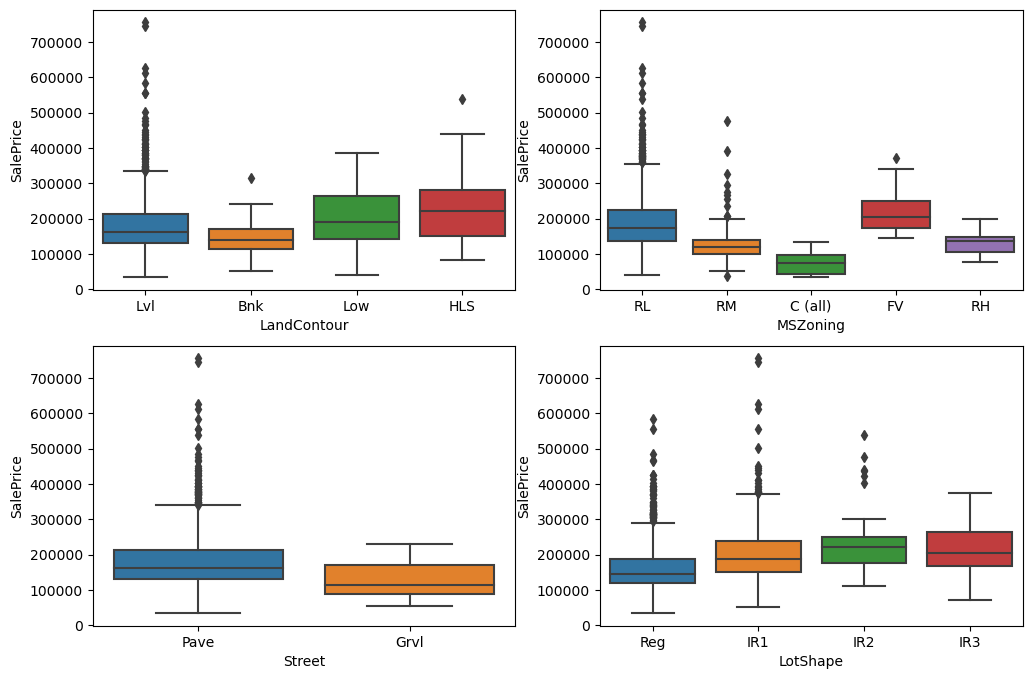

In [16]:
draw_sub_plots(data, np.array([['LandContour', 'MSZoning'], ['Street', 'LotShape']]), 'SalePrice', sns.boxplot)

**Observations**:
- **Land Countour**: **Hillside** property has the higher median sale price whereas **Banked** property has a lower median sale price.
- **MSZoning**: **Floating Village Residential** property has higher median sale price whereas **Commercial** has lower median sale price
- **Street**: Properties having **Paved** access have higher median price than **Gravel** access.
- **LotShape**: Properties having **Regular** shape are priced lower and **Moderately Irregular** properties are priced Higher.

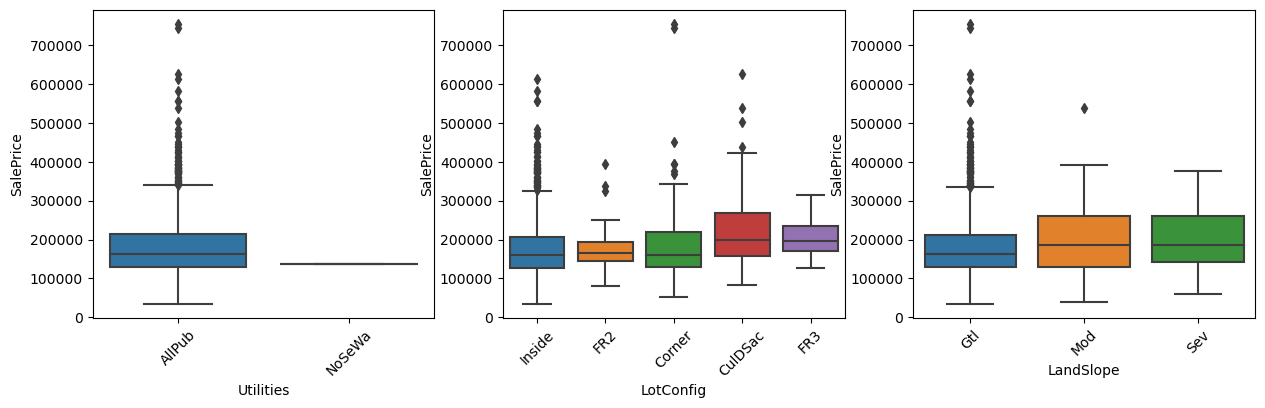

In [17]:
draw_sub_plots(data, np.array([ ['Utilities', 'LotConfig', 'LandSlope']]), 'SalePrice', sns.boxplot)

- **Utilities**: **All Public Utilities** property has a slightly higher median sale price.
- **LotConfig**: **Cul-de-sac** property has higher median sale price whereas **Inside Lot** has a lower median price.
- **LandSlope**: Properties having **Sev** slope have higher median price.

###### Creating 'Conditions' column which is a concatenation of 'Condition1' and 'Condition2' so that we can evaluate the total conditions what fetch the highest sale price.

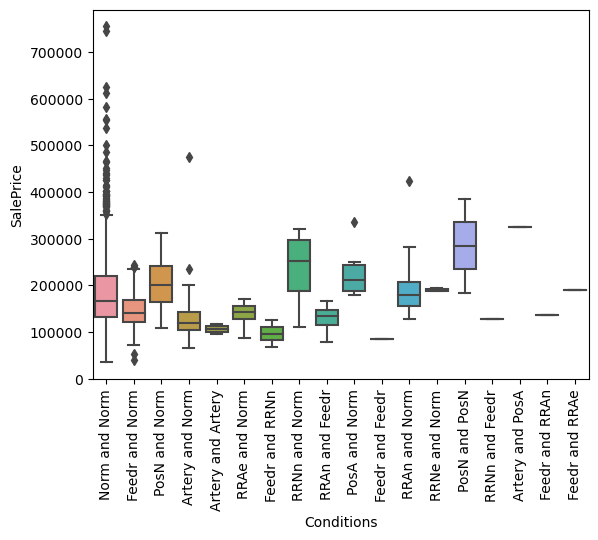

In [18]:
data['Conditions'] = data['Condition1'] + ' and ' +data['Condition2']
data.drop(['Condition1','Condition2'], axis=1, inplace=True)
sns.boxplot(data=data, x='Conditions', y='SalePrice')
plt.xticks(rotation=90)
plt.show()

**Observations**:
Although data is lesser, the house having **Artery** and **Adjacent to postive off-site feature** fetches the highest median price.
There are lot of outliers for **Normal** and **Normal** Conditions.

###### Analysing 'MSSubClass' 

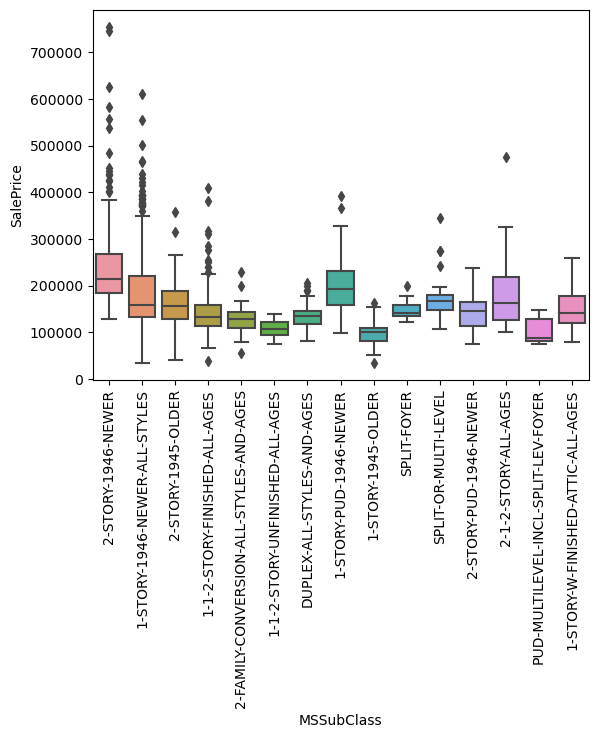

In [19]:
sns.boxplot(data=data, x='MSSubClass', y='SalePrice')
plt.xticks(rotation=90)
plt.show()

**Observations**:
**2-STORY 1946 & NEWER** type of property fetches highest median sale price and has lot of outliers.
However there are outliers in few other categories as well.

###### Analysing 'Neighborhood'

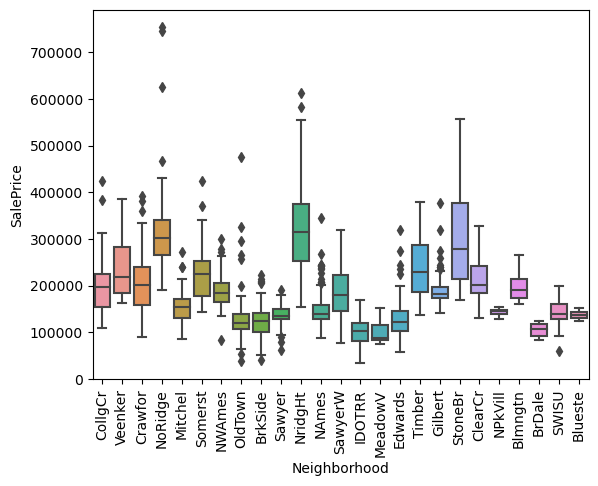

In [20]:
sns.boxplot(data=data, x='Neighborhood', y='SalePrice')
plt.xticks(rotation=90)
plt.show()

**Observations**:
Properties in **Northridge Heights** and **Northridge** have highest median price.

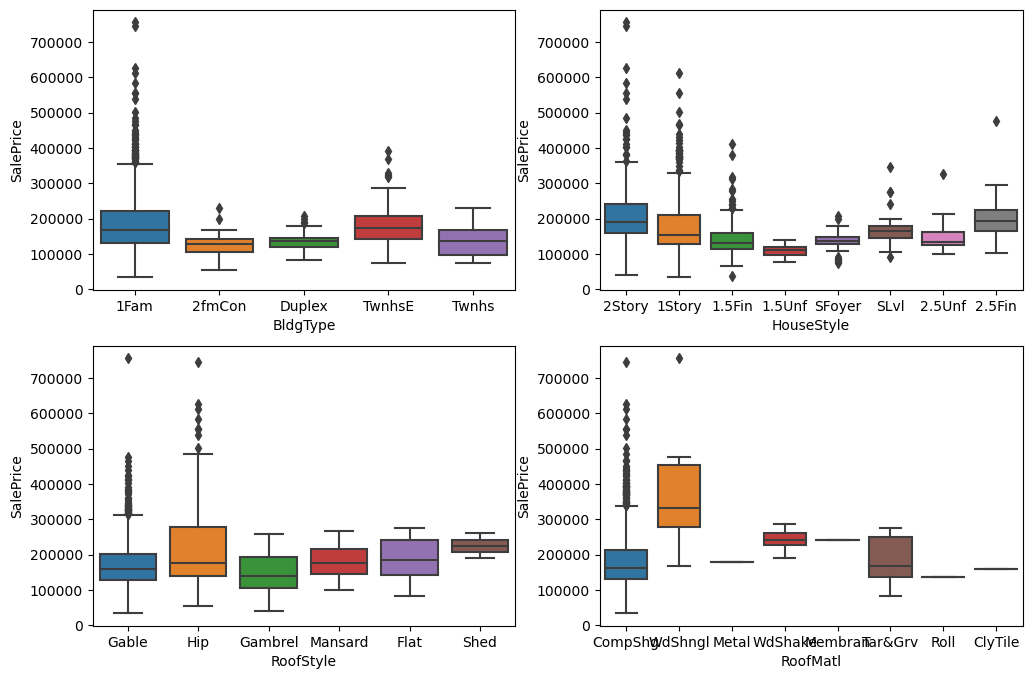

In [21]:
draw_sub_plots(data, np.array([['BldgType', 'HouseStyle'], ['RoofStyle', 'RoofMatl']]), 'SalePrice', sns.boxplot)

**Observations**:
- **BldgType**: Properties with Building type **Townhouse End Unit** and **Single-family Detached** fetch highest median Sale Price. **Single-family Detached** has lot of outliers.
- **HouseStyle**: Properties with Style of dwelling **Two and one-half story: 2nd level finished** and **Two story** fetch highest median Sale Price. **Two story** and **One story** has lot of outliers.
- **RoofStyle**: Properties having roof style **Shed** fetches highest median Sale Price. **Gable** and **Hip** have lot of outliers.
- **RoofMatl**: Properties having Roof Material **Wood Shingles** fetches highest median Sale Price. **Standard (Composite) Shingle** has lot of outliers.

###### Creating an 'Exteriors' column which is a concatenation of 'Exterior1st' and 'Exterior2nd' columns.

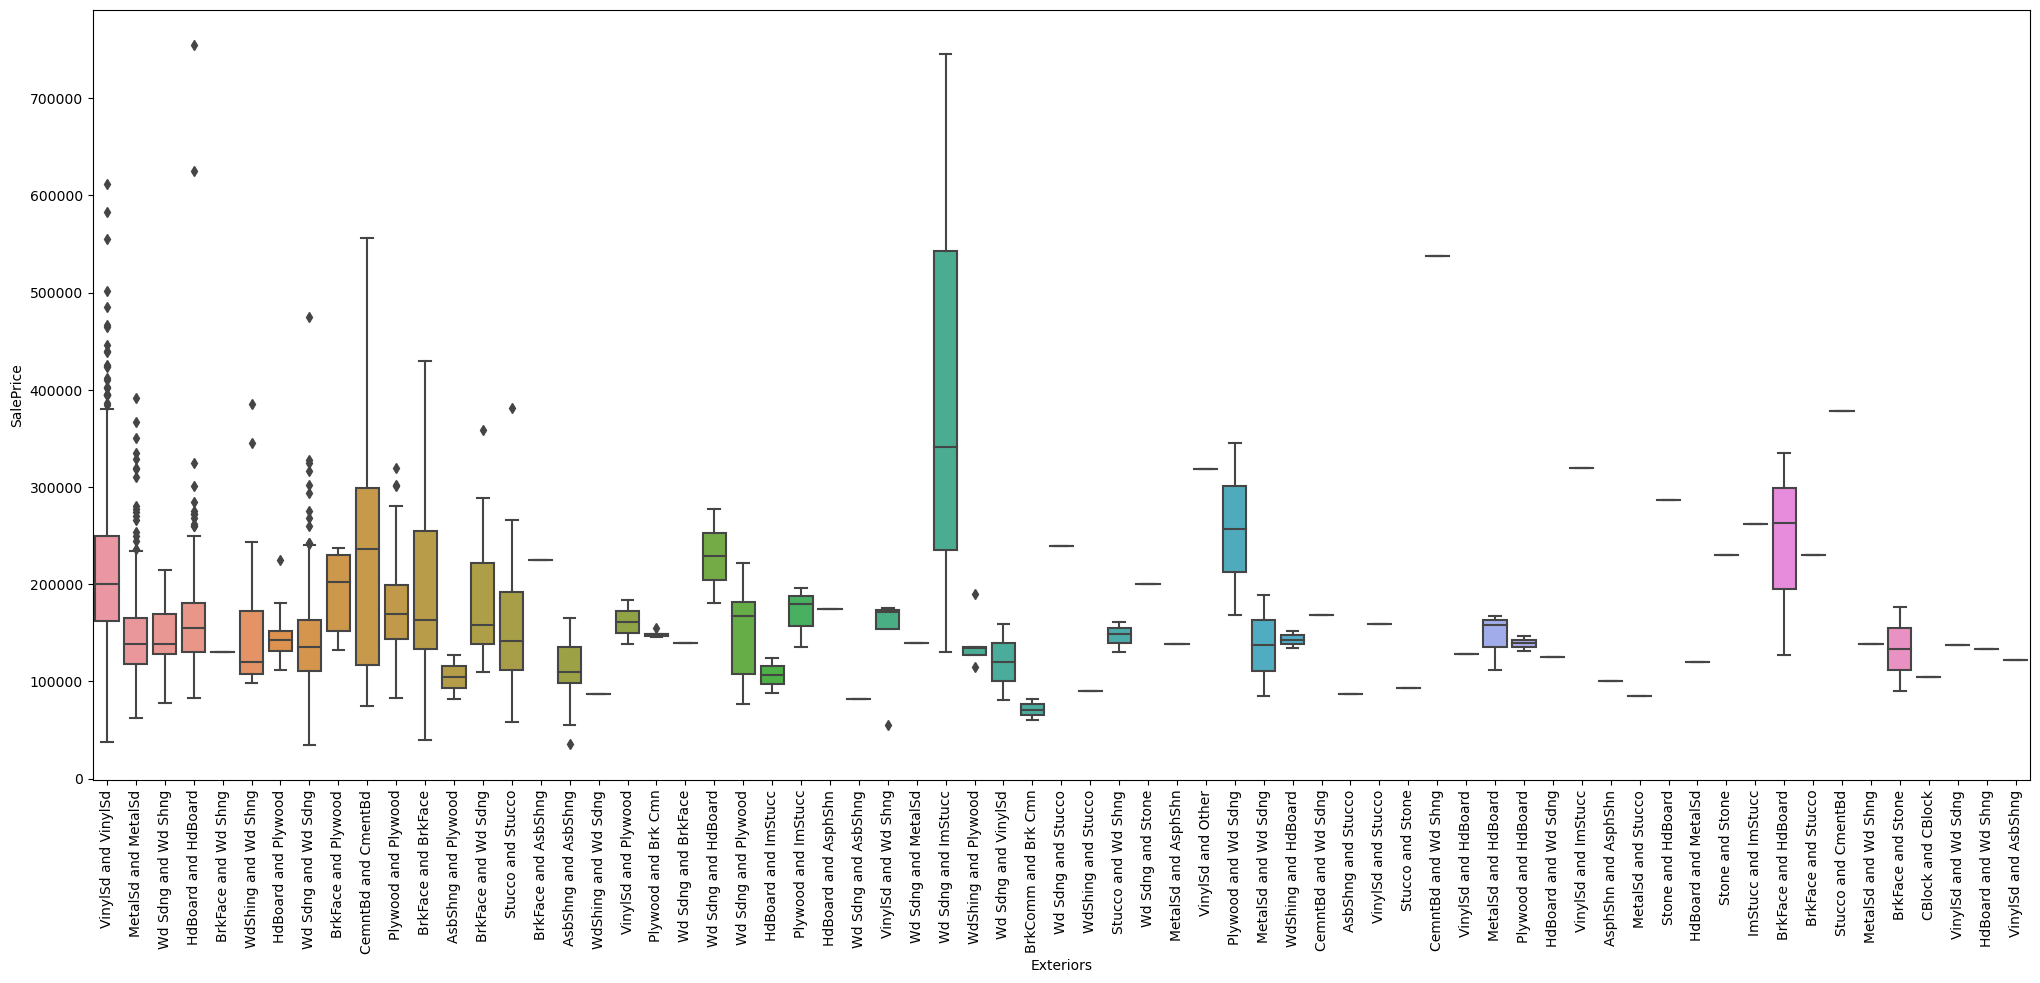

In [22]:
data['Exteriors'] = data['Exterior1st'] + ' and ' + data['Exterior2nd']
data.drop(['Exterior1st','Exterior2nd'], axis=1, inplace=True)
plt.figure(figsize =(25, 10))
sns.boxplot(data=data, x='Exteriors', y='SalePrice')
plt.xticks(rotation=90)
plt.show()

**Observations**: 
- Combination of **Cement Board** and **Wood Siding** Exterior fetches maximum median Sale Price, although the data for this combination is very less.

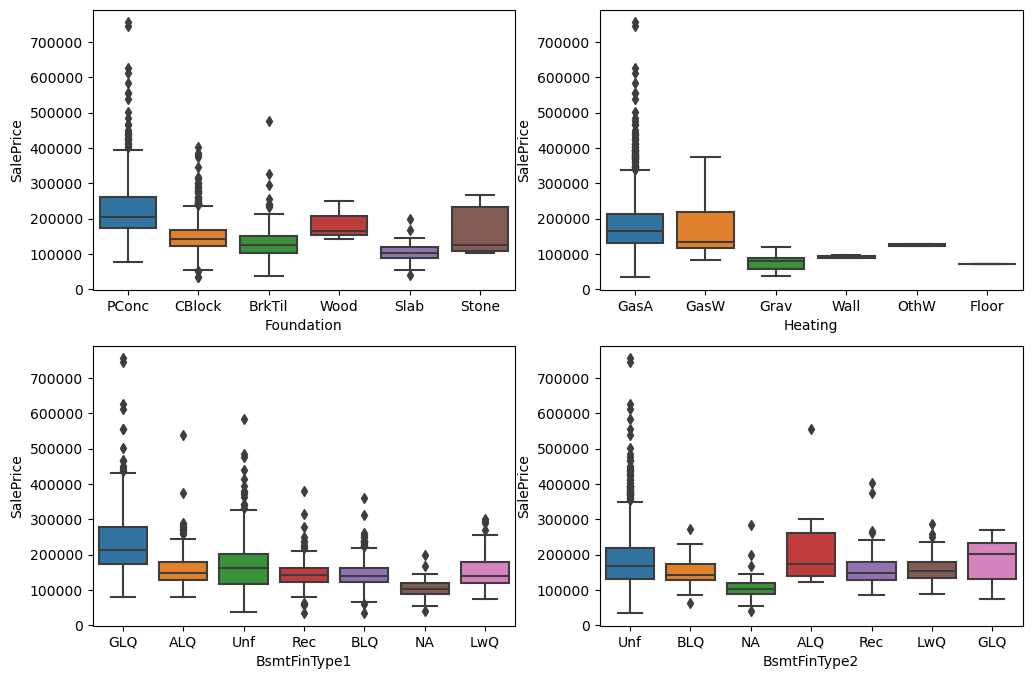

In [23]:
draw_sub_plots(data, np.array([ ['Foundation', 'Heating'], ['BsmtFinType1', 'BsmtFinType2']]), 'SalePrice', sns.boxplot)

**Observations**:
- **Foundation**: **Poured Contrete** type foundation fetches the highest median Sale Price.
- **Heating**: **Gas forced warm air furnace** type heating fetches the highest median Sale Price.
- **BsmtFinType1** and **BsmtFinType2**: **Good Living Quarters** fetched highest median Sale Price.

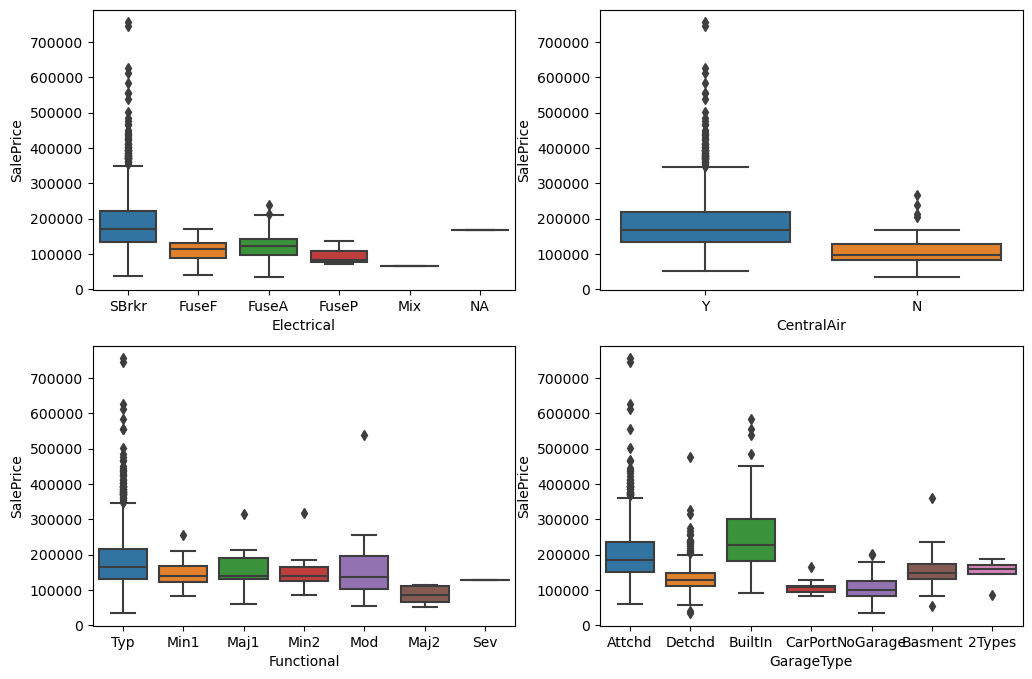

In [24]:
draw_sub_plots(data, np.array([ ['Electrical', 'CentralAir'], ['Functional', 'GarageType']]), 'SalePrice', sns.boxplot)

**Observations**:
- **Electrical**: Properties with **Standard Circuit Breakers & Romex** fetch higher median sale price.
- **CentralAir**: Properties with Central Air Conditioning fetch higher median sale price.
- **Functional**: Properties with **Typical Functionality** fetch higher median sale price.
- **GarageType**: Properties with **Attached to home** fetch higher median sale price.

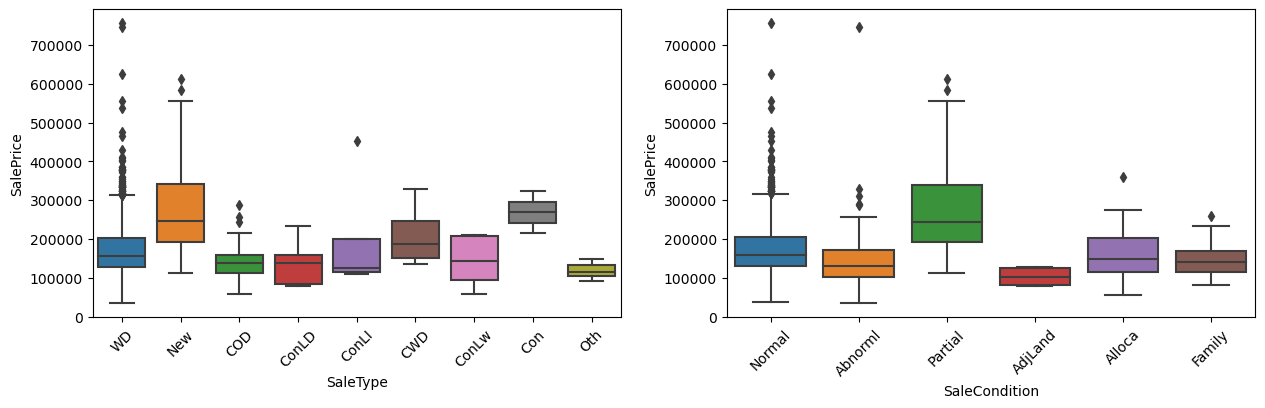

In [25]:
draw_sub_plots(data, np.array([ [ 'SaleType', 'SaleCondition']]), 'SalePrice', sns.boxplot)

**Observations**:
- **SaleType**: **Contract 15% Down payment regular terms** Sale Type fetches higher median Sale Price.
- **SaleCondition**: **Home was not completed when last assessed (associated with New Homes)** Sale Condition fetches higher median Sale Price.

##### Analyzing numeric variables

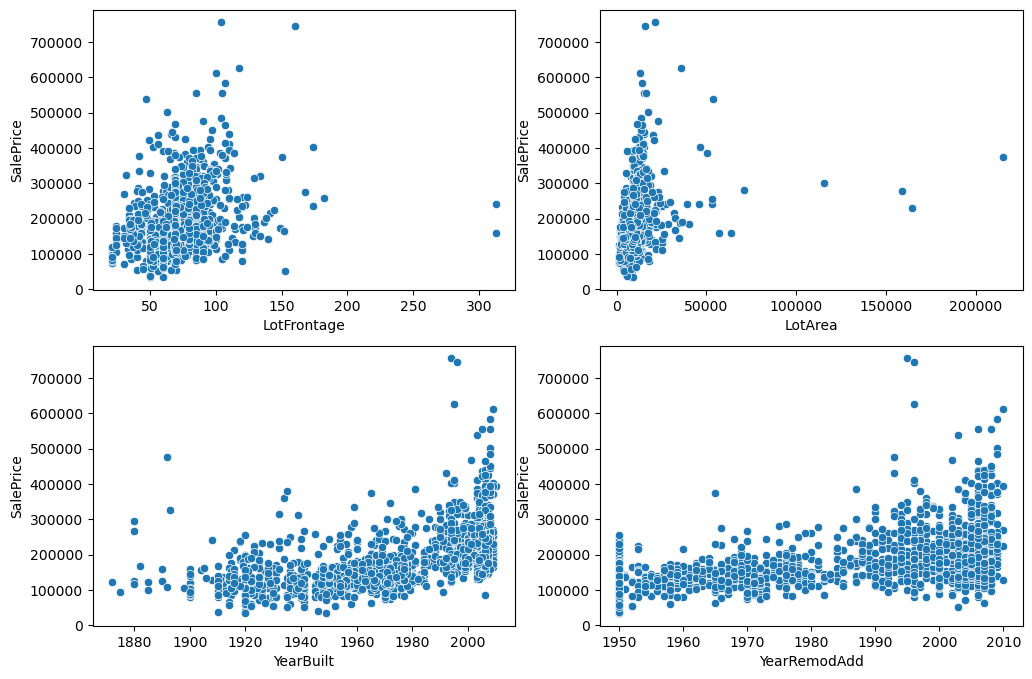

In [26]:
draw_sub_plots(data, np.array([ ['LotFrontage', 'LotArea'], ['YearBuilt', 'YearRemodAdd']]), 'SalePrice', sns.scatterplot)

**Observations**:
- **LotFrontage**: There is a definite trend of increase in **Sale Price** and increase in **Linear feet of street connected to property**
- **LotArea**: There is a mild trent of increase in  **Sale Price** and increase in **Lot size in square feet**.
- **YearBuilt**: Newer the property, more the Sale price.
- **YearRemodAdd**: CLosely following **YearBuilt** probably because not many properties are remodelled.

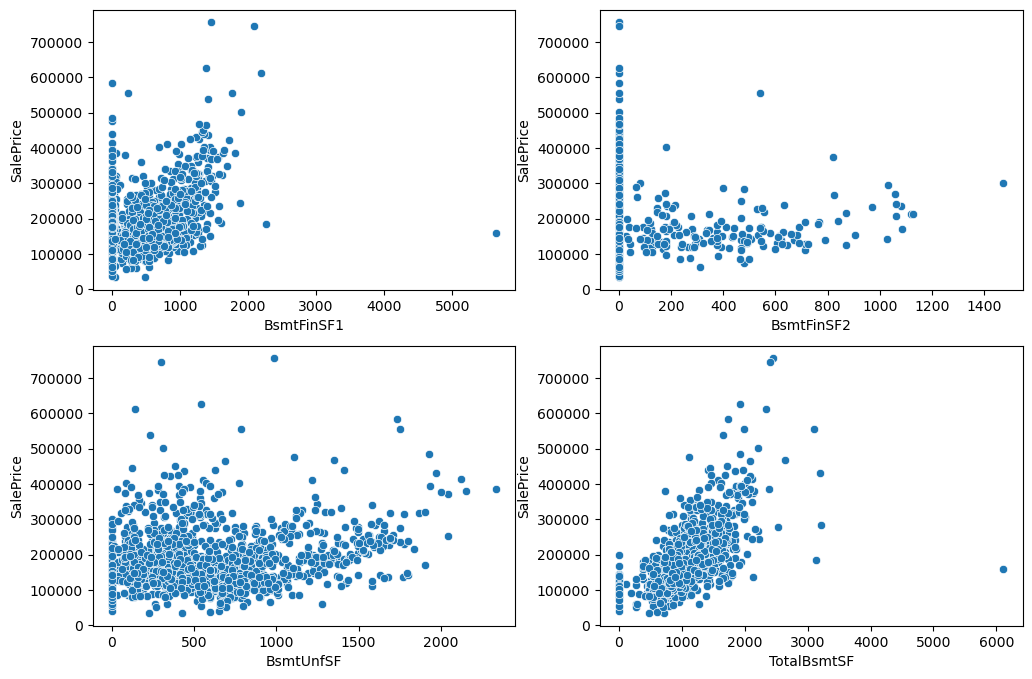

In [27]:
draw_sub_plots(data, np.array([ ['BsmtFinSF1', 'BsmtFinSF2'], ['BsmtUnfSF', 'TotalBsmtSF']]), 'SalePrice', sns.scatterplot)

**Observations**:
- There is a definite positive trend in **BsmtFinSF1** and **TotalBsmtSF** vs the **SalePrice**.
- *BsmtFinSF2* and *BsmtUnfSF* seems to have much lesser impact.

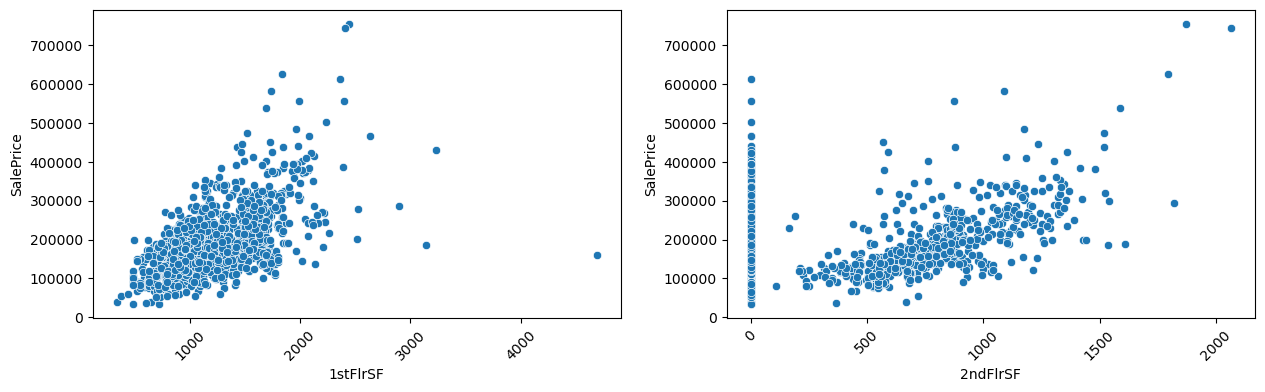

In [28]:
draw_sub_plots(data, np.array([ ['1stFlrSF', '2ndFlrSF'] ]), 'SalePrice', sns.scatterplot)

**Observations**: There is a very strong trend positive trend in **1stFlrSF**, **2ndFlrSF** vs **SalePrice**.

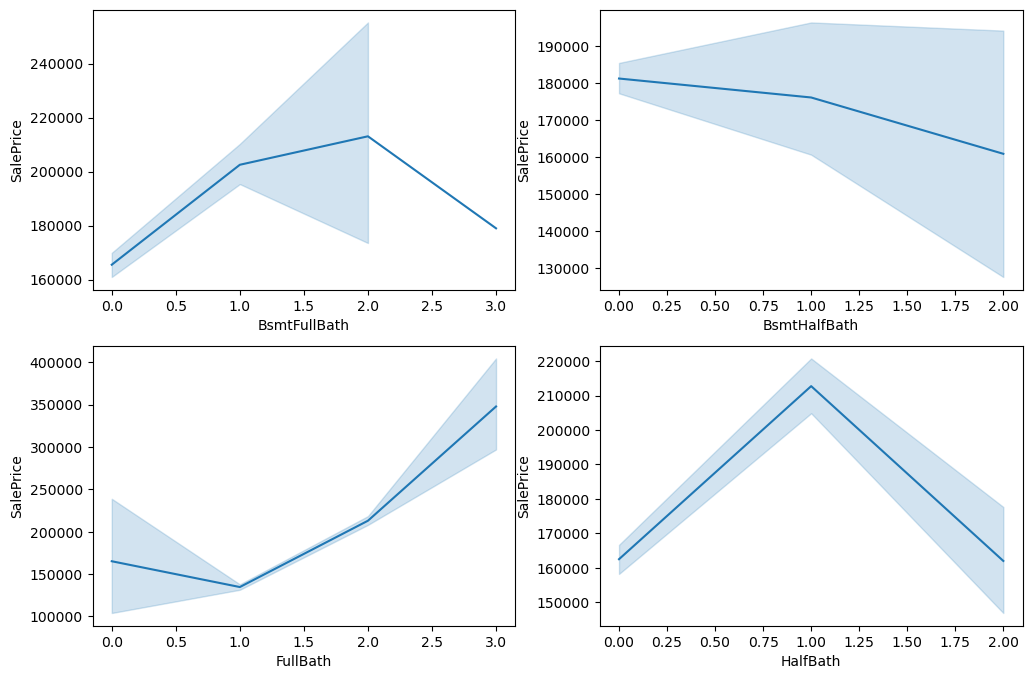

In [29]:
draw_sub_plots(data, np.array([ ['BsmtFullBath', 'BsmtHalfBath'], ['FullBath', 'HalfBath'] ]), 'SalePrice', sns.lineplot)

**Observations**:
- *Half Baths* don't contribute to sale prices whereas *Full Baths* do.

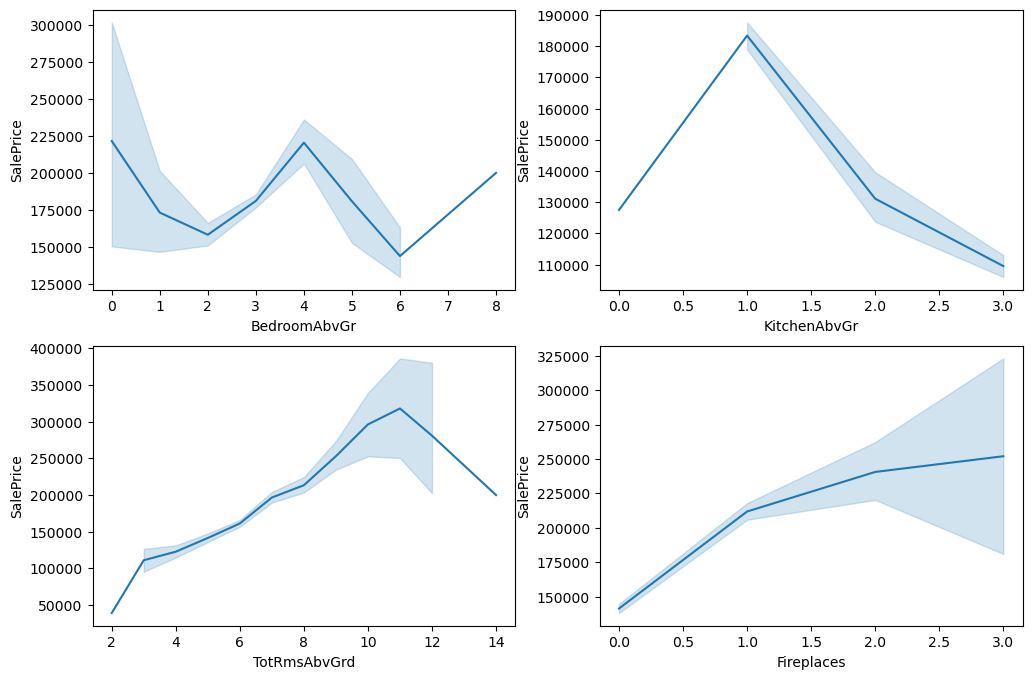

In [30]:
draw_sub_plots(data, np.array([ ['BedroomAbvGr', 'KitchenAbvGr'], ['TotRmsAbvGrd', 'Fireplaces'] ]), 'SalePrice', sns.lineplot)

**Observations**:
- **BedroomAbvGr** - Sale Price increases till 4 bedrooms and decreases thereafter (We don't have enough data for 7 and 8).
- **KitchenAbvGr** - Sale Price for a single Kitchen is maximum and decreases thereafter.
- **TotRmsAbvGrd** - Total Rooms till 11 rooms show positive trend with Sale Price then decreases thereafter.
- **Fireplaces** - More fireplaces are preferred.

**Overall Trend**: If a property has number of rooms beyond useful limit, it does not guarantee a higher Sale Price.

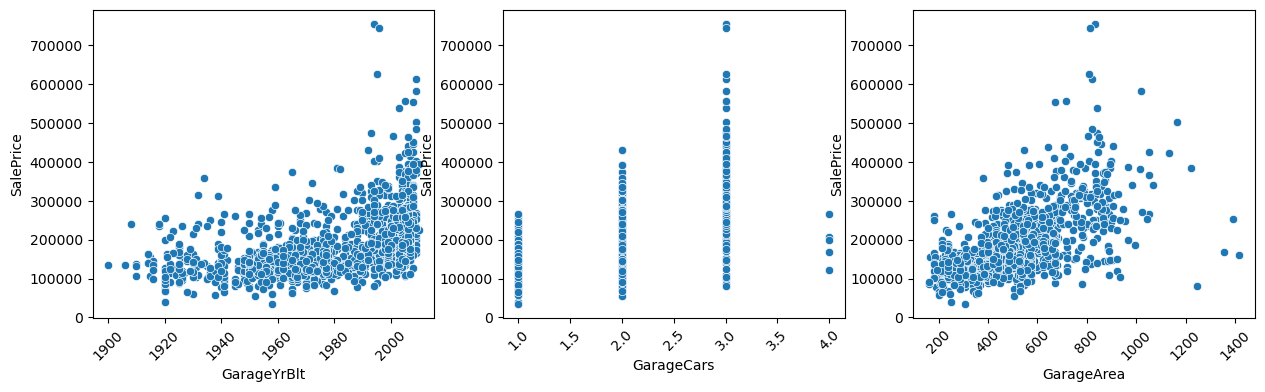

In [31]:
draw_sub_plots(data[data['GarageCars'] > 0][['GarageYrBlt', 'GarageCars', 'GarageArea', 'SalePrice']], np.array([ ['GarageYrBlt', 'GarageCars', 'GarageArea'] ]), 'SalePrice', sns.scatterplot)

**Observations**:
- **GarageYrBlt**: There is a very mild trend between Year Built and Sale Price/
- **GarageCars**: Sale Price increases till 3 Car capacity, after which there is a decline in Sale Price. (Similar to tends observed for number of rooms).
- **GarageArea**: There is a clear positive trend between Garage Area and Sale Price.

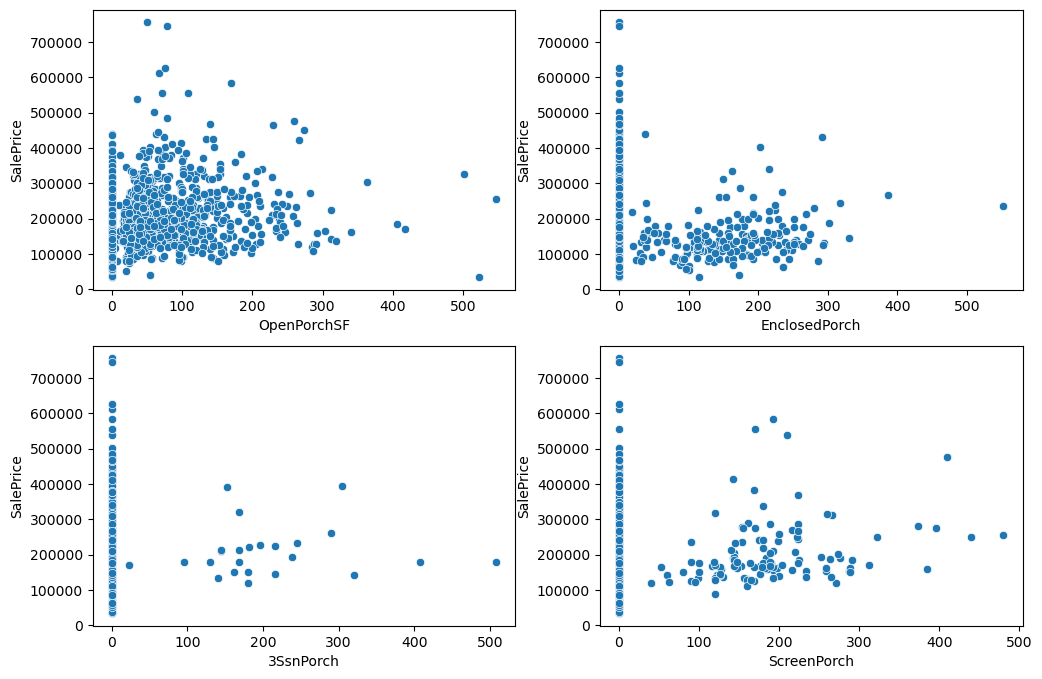

In [32]:
draw_sub_plots(data, np.array([ ['OpenPorchSF', 'EnclosedPorch'], ['3SsnPorch', 'ScreenPorch']]), 'SalePrice', sns.scatterplot)

**Observations**: In general, there is a weak trend between Porch sq ft and the Sale Price.

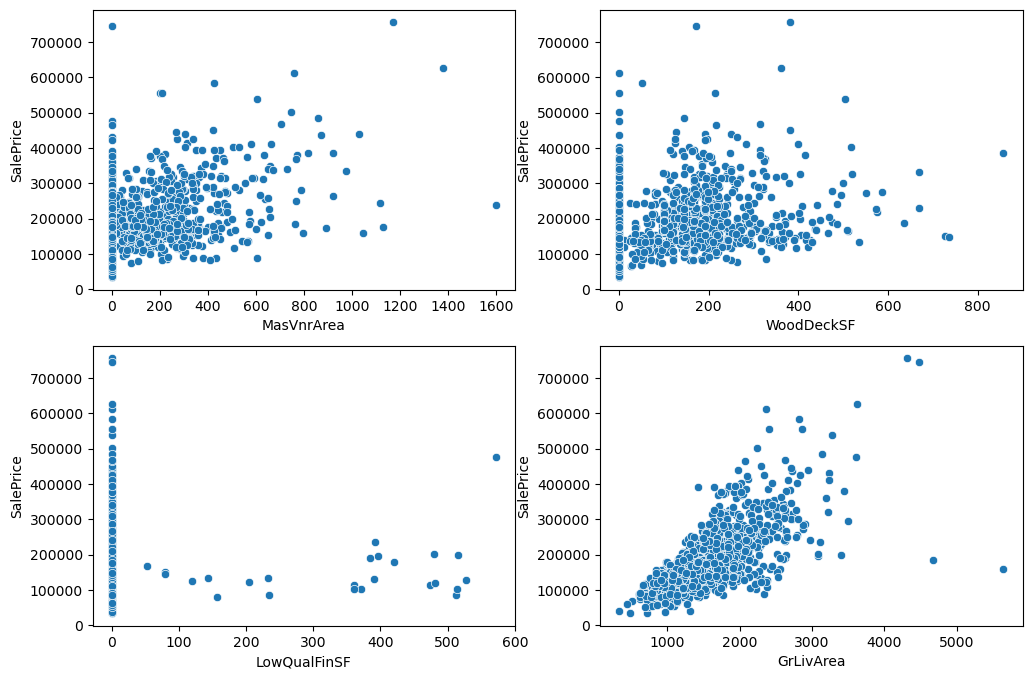

In [33]:
draw_sub_plots(data, np.array([ ['MasVnrArea', 'WoodDeckSF'], ['LowQualFinSF', 'GrLivArea']]), 'SalePrice', sns.scatterplot)

**Observations**:
- **GrLivArea**: There is a clear positive trend between GrLivArea and Sale Price.
- **MasVnrArea**, **WoodDeckSF**: There is a mild positive trend.
- **LowQualFinSF**: No trend observed.

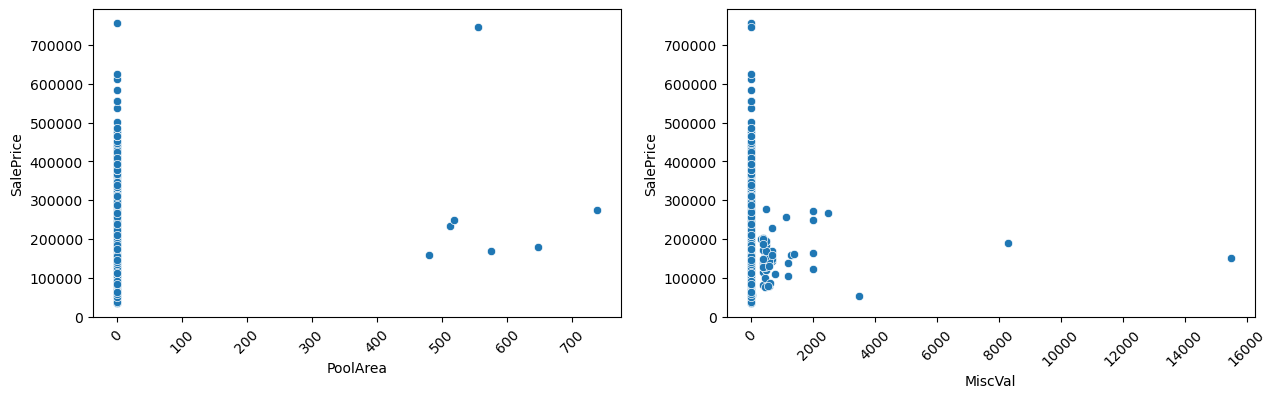

In [34]:
draw_sub_plots(data, np.array([ ['PoolArea', 'MiscVal']]), 'SalePrice', sns.scatterplot)

**Observations**: No trend seen for **PoolArea** or **MiscVal** against Sale Price.

###### Analyzing 'quality' variables

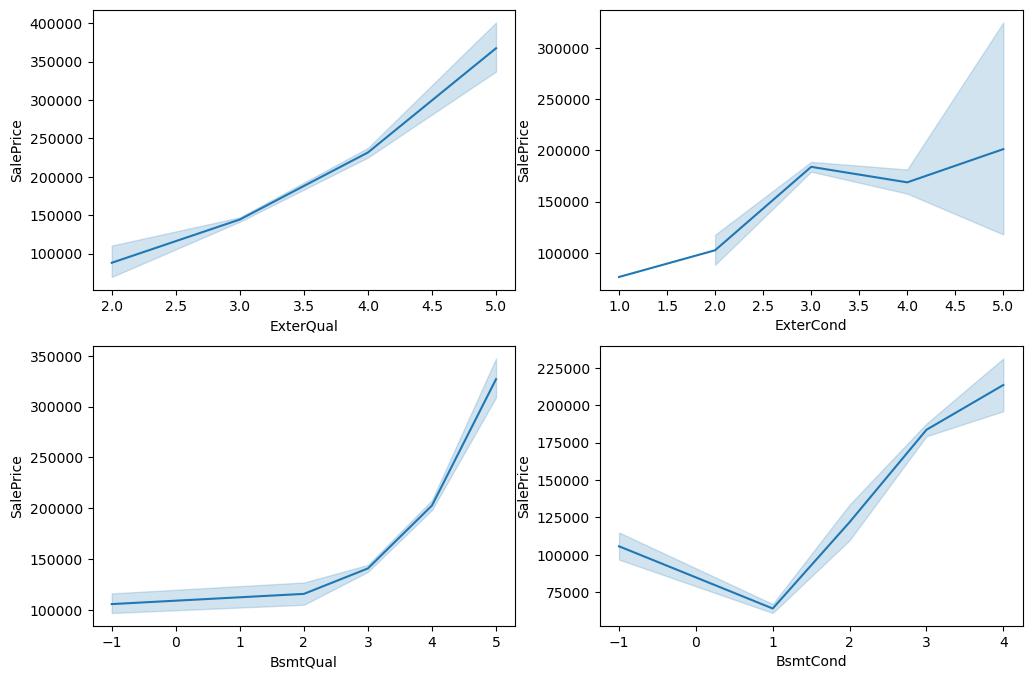

In [35]:
draw_sub_plots(data, np.array([ ['ExterQual', 'ExterCond'], ['BsmtQual', 'BsmtCond']]), 'SalePrice', sns.lineplot)

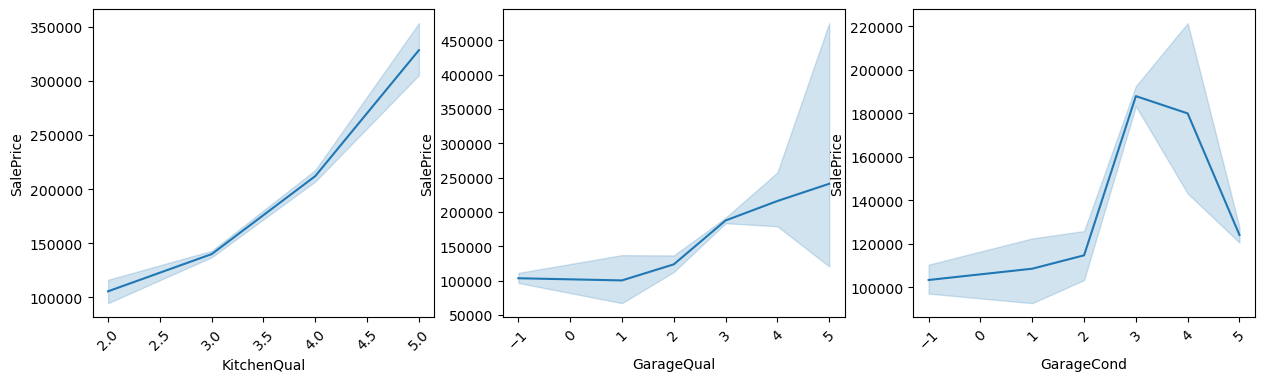

In [36]:
draw_sub_plots(data, np.array([ ['KitchenQual', 'GarageQual', 'GarageCond']]), 'SalePrice', sns.lineplot)

**Observations**: General trend is that the Sale Price increases as quality increases.
Exception to the trend is 'GarageCond'. This is possibly because of lesser data for 'Excellent' Garand Condition.

###### Checking for correlation

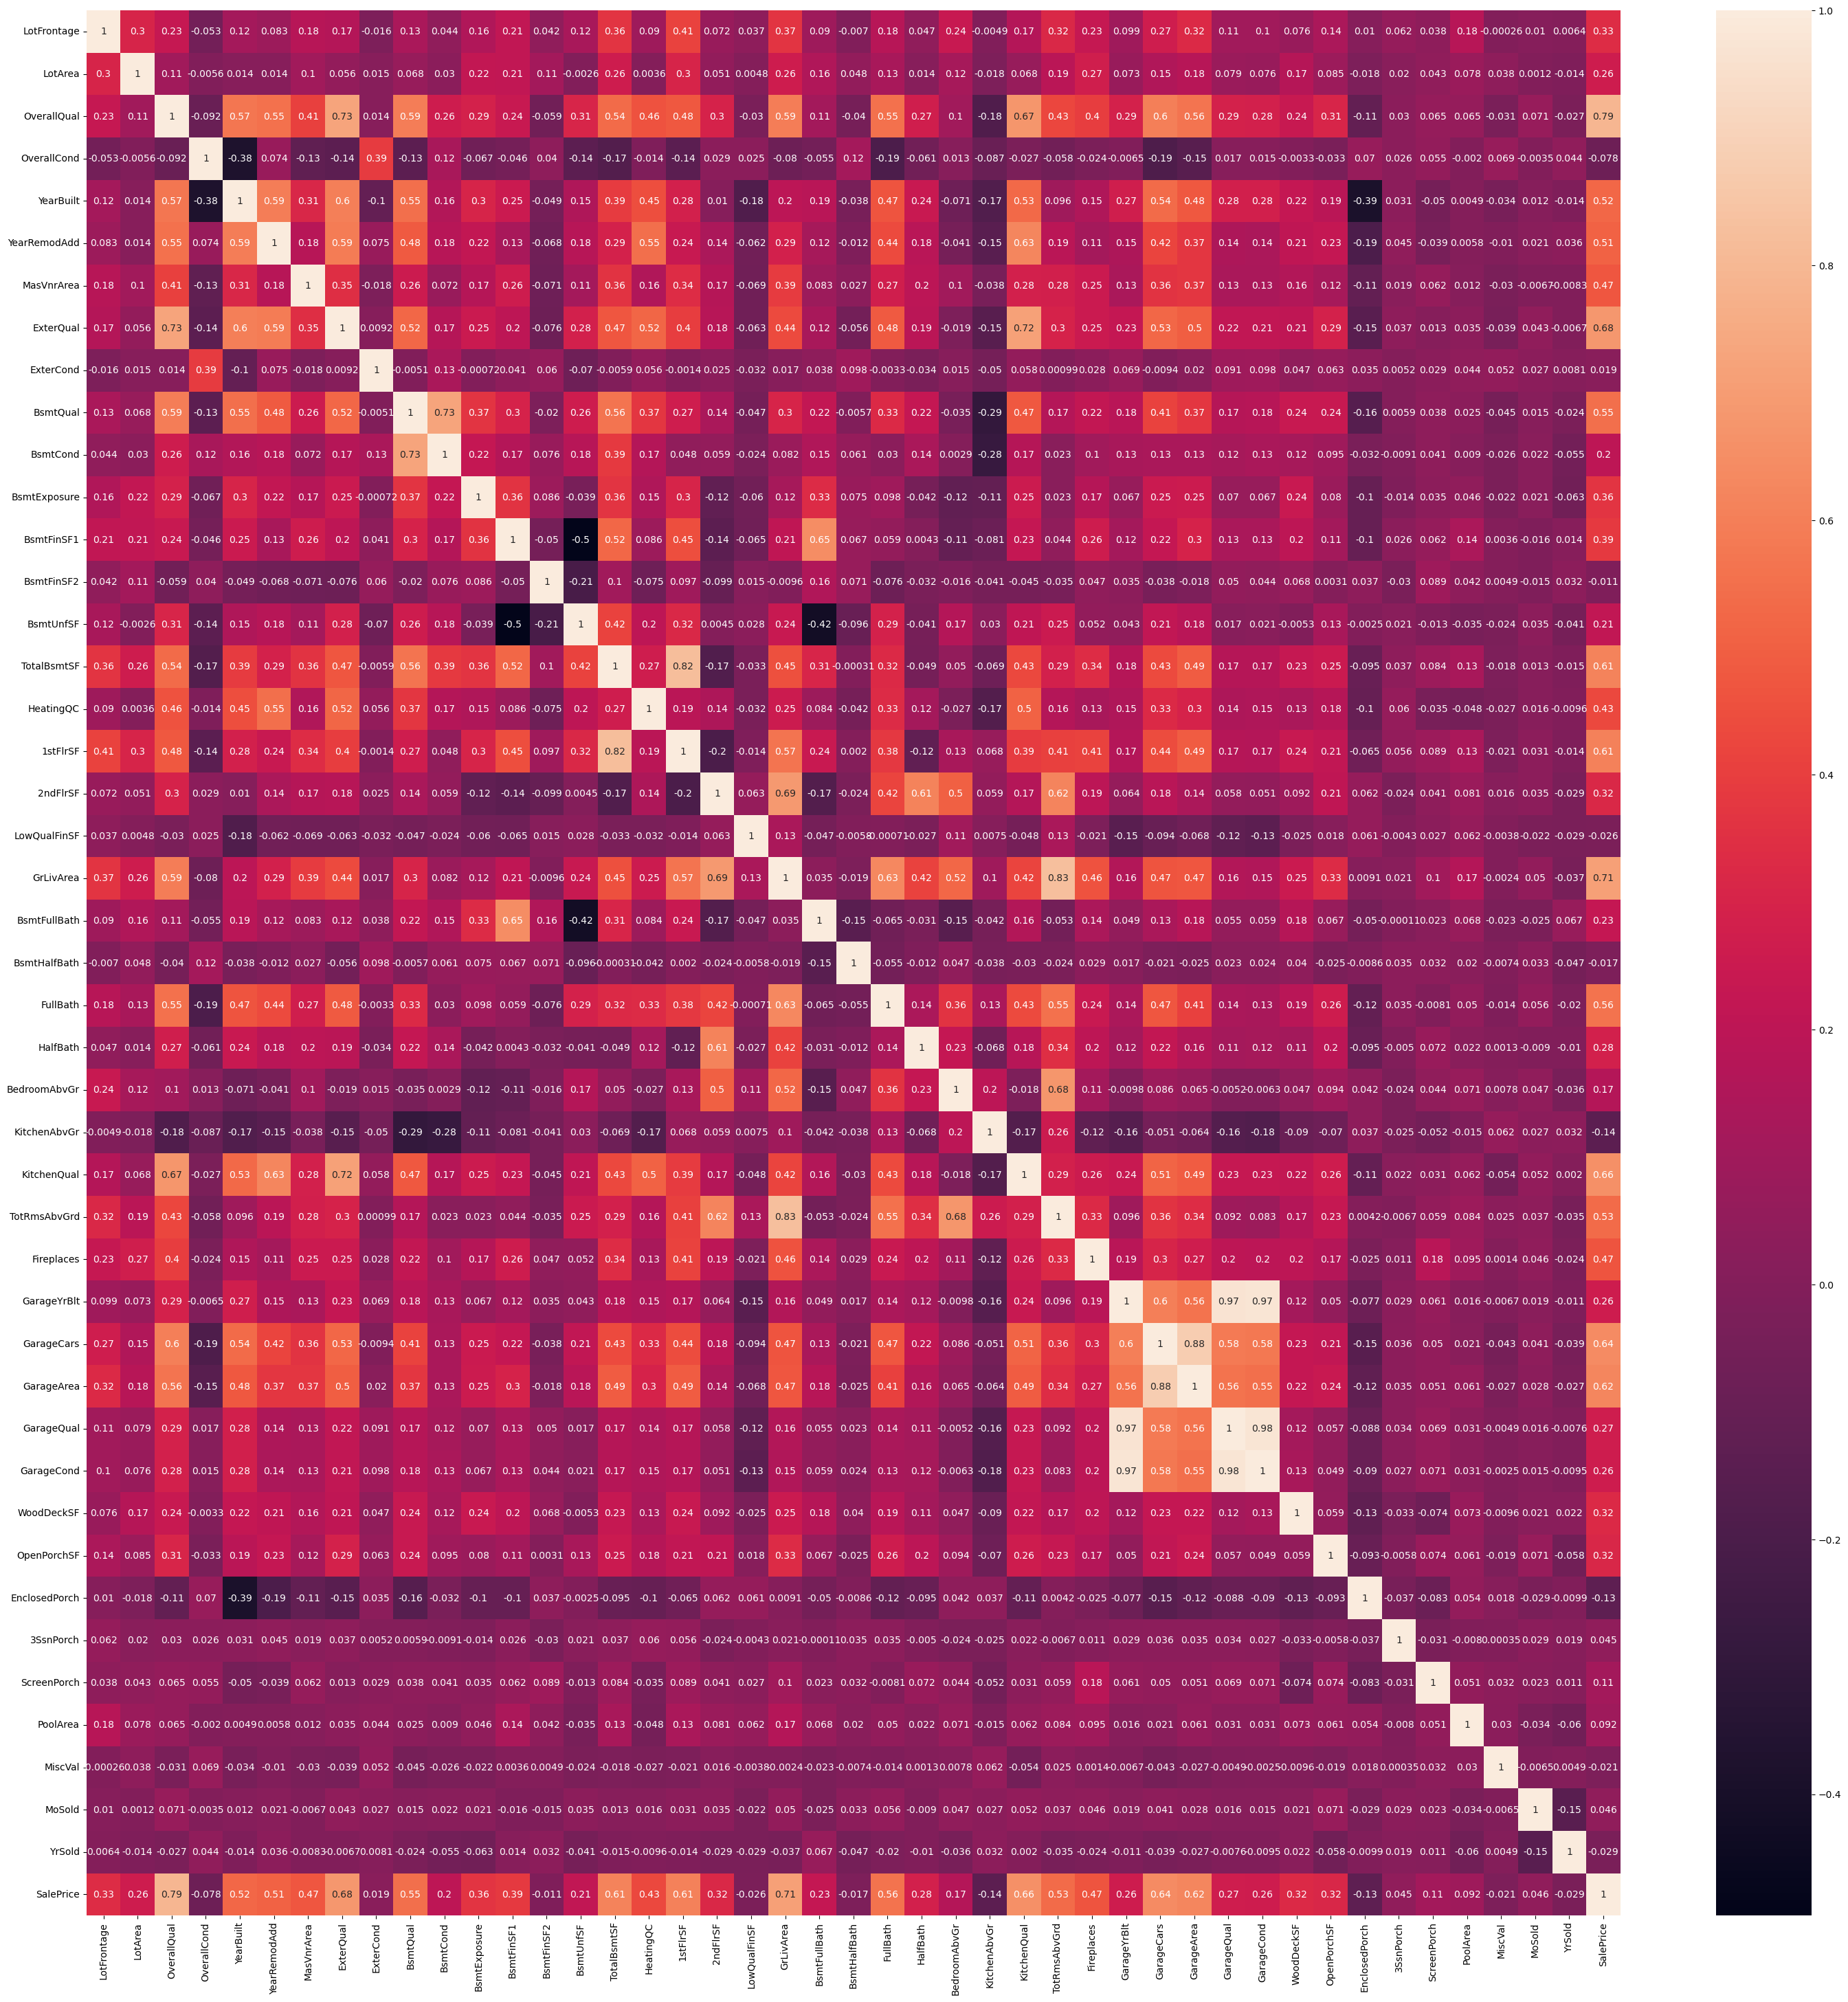

In [37]:
plt.figure(figsize = (36, 36))
sns.heatmap(data.select_dtypes(include=['int32', 'int64', 'float64']).corr(), annot = True)
plt.show()

###### Numeric Variables having  an absolute correlation of > 0.5 with Sale Price.

In [38]:
corr_df = data.select_dtypes(include=['int32', 'int64', 'float64']).corr()
corr_df[np.absolute(corr_df['SalePrice']) > 0.5][['SalePrice']].sort_values(by=['SalePrice'], ascending=False)

SalePrice
SalePrice      1.000000
OverallQual    0.790982
GrLivArea      0.708624
ExterQual      0.682639
KitchenQual    0.659600
GarageCars     0.640409
GarageArea     0.623431
TotalBsmtSF    0.613581
1stFlrSF       0.605852
FullBath       0.560664
BsmtQual       0.545219
TotRmsAbvGrd   0.533723
YearBuilt      0.522897
YearRemodAdd   0.507101

### Converting Categorical Variables into numerical using 'dummies'

###### Finding and verifying that the below are the data types that will be converted into numerical variables.

In [39]:
categorical_columns = data.select_dtypes(exclude=['int32', 'int64', 'float64']).columns
categorical_columns

Index(['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'BldgType',
       'HouseStyle', 'RoofStyle', 'RoofMatl', 'Foundation', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'CentralAir', 'Electrical', 'Functional',
       'GarageType', 'GarageFinish', 'PavedDrive', 'SaleType', 'SaleCondition',
       'Conditions', 'Exteriors'],
      dtype='object')

In [40]:
categorical_columns_dummies = pd.get_dummies(data[categorical_columns], drop_first=True)
data.drop(categorical_columns, axis=1, inplace=True)
data = pd.concat([data, categorical_columns_dummies], axis=1)


In [41]:
categorical_columns_dummies.head()

print(len(categorical_columns))

27


### Splitting into Training and Test data set

In [42]:
np.random.seed(42)
df_train, df_test = train_test_split(data, train_size = 0.7, test_size = 0.3, random_state = 100)

###### Scaling using StandardScaler Scaling. Applying Scaling to all variables (since all variables are numeric now)

In [43]:
scaler = StandardScaler()
df_train[df_train.columns] = scaler.fit_transform(df_train[df_train.columns])
df_train.head()

LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
210     -0.115302 -0.473765    -0.779861     0.383154  -1.524903   
318      0.926898 -0.056845     0.649651    -0.533005   0.717033   
239     -0.794998 -0.169324    -0.065105    -1.449164  -0.865510   
986     -0.477806 -0.502297    -0.065105     2.215472  -2.019448   
1416    -0.432493  0.082905    -1.494617     0.383154  -2.843689   

      YearRemodAdd  MasVnrArea  ExterQual  ExterCond  BsmtQual  ...  \
210      -1.694350   -0.558025  -0.698260  -0.260816 -0.442852  ...   
318       0.390956    0.809137   1.053395  -0.260816  0.540087  ...   
239      -1.694350   -0.558025  -0.698260  -0.260816 -0.442852  ...   
986       0.875911   -0.558025  -0.698260   2.602556 -0.442852  ...   
1416     -1.694350   -0.558025  -0.698260  -0.260816 -0.442852  ...   

      Exteriors_Wd Sdng and Stone  Exteriors_Wd Sdng and Stucco  \
210                           0.0                     -0.031311   
318                           0.0                     -0.031311   
239                           0.0                     -0.031311   
986                           0.0                     -0.031311   
1416                          0.0                     -0.031311   

      Exteriors_Wd Sdng and VinylSd  Exteriors_Wd Sdng and Wd Sdng  \
210                       -0.044302                      -0.370096   
318                       -0.044302                      -0.370096   
239                       -0.044302                      -0.370096   
986                       -0.044302                      -0.370096   
1416                      -0.044302                      -0.370096   

      Exteriors_Wd Sdng and Wd Shng  Exteriors_WdShing and HdBoard  \
210                       -0.088867                      -0.044302   
318                       -0.088867                      -0.044302   
239                       -0.088867                      -0.044302   
986                       -0.088867                      -0.044302   
1416                      -0.088867                      -0.044302   

      Exteriors_WdShing and Plywood  Exteriors_WdShing and Stucco  \
210                       -0.054286                           0.0   
318                       -0.054286                           0.0   
239                       -0.054286                           0.0   
986                       -0.054286                           0.0   
1416                      -0.054286                           0.0   

      Exteriors_WdShing and Wd Sdng  Exteriors_WdShing and Wd Shng  
210                       -0.031311                       -0.11791  
318                       -0.031311                       -0.11791  
239                       -0.031311                       -0.11791  
986                       -0.031311                       -0.11791  
1416                      -0.031311                       -0.11791  

[5 rows x 265 columns]

###### Splitting into X_train and y_train

In [44]:
y_train = df_train.pop('SalePrice')
X_train = df_train

###### Splitting into X_test and y_test

In [45]:
df_test[df_test.columns] = scaler.transform(df_test[df_test.columns])
y_test = df_test.pop('SalePrice')
X_test = df_test

### Model Building and Evaluation

###### Linear Regression

In [46]:
lm = LinearRegression()
lm.fit(X_train, y_train)
print(lm.intercept_)
print(lm.coef_)

-0.00031012920287168394
[ 2.99770816e-02  8.36051668e-02  1.34283886e-01  8.60737774e-02
  7.62219472e-02  1.01733762e-02  4.77859828e-02  4.06407172e-02
 -1.65048491e-02  7.28321802e-02 -3.60458385e-02  7.86138976e-02
  4.03332182e+11  1.48210618e+11  3.89218716e+11 -3.98302177e+11
 -5.01573132e-03 -7.07964032e+11 -7.74295412e+11 -8.57504975e+10
  9.46333326e+11  1.66045658e-02 -4.52128678e-05 -3.73294552e-03
 -7.55105796e-03 -3.99940216e-02 -4.41780546e-02  3.28069714e-02
  1.16544304e-02  9.90194120e-03  5.13347199e-01  3.39470015e-02
  3.55003493e-02  7.70504380e-02 -1.15498454e-02  7.34467656e-03
  1.91593741e-02 -1.05675772e-02  1.38221373e-02  1.24523392e-02
  3.00016686e-02  9.50451735e-03 -1.33255174e-02  3.34228372e-04
 -5.87710291e-03  7.95639404e-03 -1.11931946e-02 -5.88077049e-03
  5.66081219e-03 -4.04711107e-02 -1.38560731e+11  9.80762860e-03
  1.63934534e-02  5.61490746e-03  1.53056187e+11 -1.20239019e-02
 -1.85012973e-02 -6.28670435e-02  9.14374061e-02  5.40953473e-02
 

###### Performing Training and Test predictions

In [47]:
y_pred_train = lm.predict(X_train)
y_pred_test = lm.predict(X_test)

###### Metrics Evaluation of Linear Regression

In [48]:
metric = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric.append(mse_test_lr**0.5)

0.9428975250556866
-6.239424114458295e+21
58.30162691814394
2.814185953530769e+24
0.05710247494431336
6.425082085686687e+21


###### Plotting Linear Assumptions

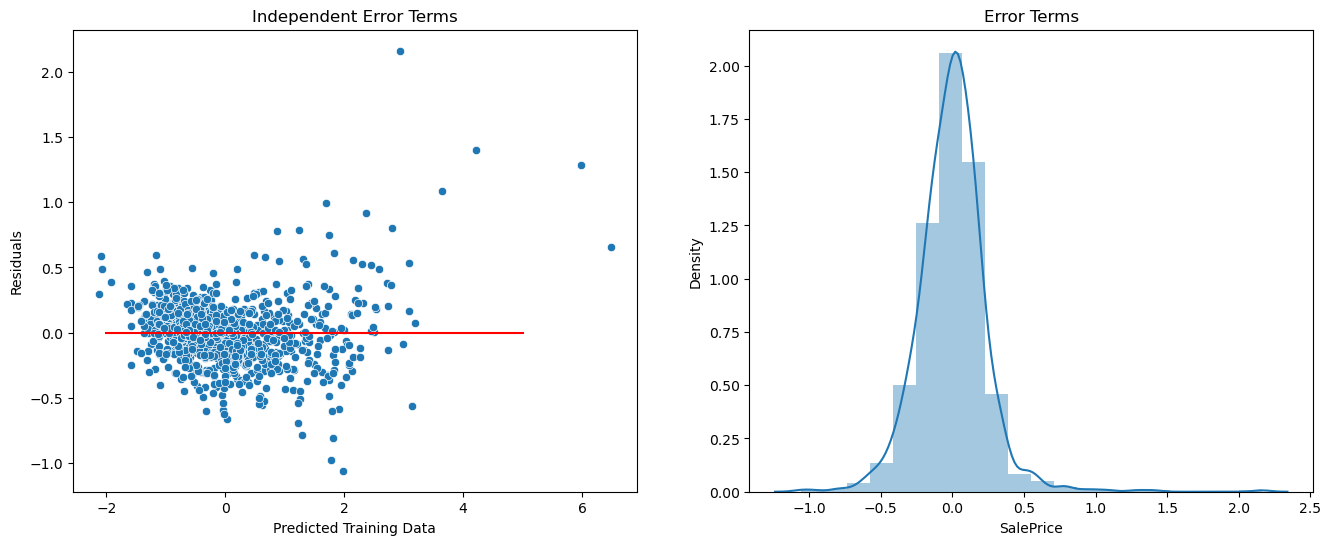

In [49]:
def plot_linear_assumptions(y_train, y_pred_train):
    residuals = y_train - y_pred_train
    fig, axes = plt.subplots(1, 2,  figsize=(16, 6))
    
    axes[0].set_xlabel("Predicted Training Data")
    axes[0].set_ylabel("Residuals")
    axes[0].set_title('Independent Error Terms')
    sns.scatterplot(ax=axes[0], x=y_pred_train, y=residuals)
    sns.lineplot(ax=axes[0], x=[-2, 5], y=[0,0], color='red')
    
    
    axes[1].set_xlabel('Errors')
    axes[1].set_title('Error Terms')
    sns.distplot(residuals, ax=axes[1],  bins = 20)

    plt.show()

plot_linear_assumptions(y_train, y_pred_train)

### Ridge Regression

In [50]:
params = {'alpha': [0.00001, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 
 0.0008, 0.0009, 0.001, 0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 
 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 
 0.85, 0.9, 0.95, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75,
 4.0, 4.25, 4.5, 4.75, 5.0, 5.25, 5.5, 5.75, 6.0, 6.25, 6.5, 6.75, 7.0, 7.25, 7.5, 7.75, 
 8.0, 8.25, 8.5, 8.75, 9.0, 9.25, 9.5, 9.75, 10.0, 20, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000 ]}

###### Performing Grid Search Cross Validation

In [51]:
ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 82 candidates, totalling 410 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [1e-05, 0.0001, 0.0002, 0.0003, 0.0004,
                                   0.0005, 0.0006, 0.0007, 0.0008, 0.0009,
                                   0.001, 0.01, 0.025, 0.05, 0.075, 0.1, 0.15,
                                   0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55,
                                   0.6, 0.65, 0.7, 0.75, 0.8, ...]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

###### Getting the best alpha

In [52]:
print(model_cv.best_params_)

{'alpha': 500}


###### Performing Regression with best alpha

In [53]:
alpha = model_cv.best_params_['alpha']
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
print(ridge.coef_)
print(ridge.intercept_)

[ 8.49182516e-03  3.80286470e-02  1.05203409e-01  3.49103037e-02
  1.58101127e-02  2.79511657e-02  5.24737293e-02  5.49516975e-02
 -1.18120722e-03  4.71620358e-02 -4.91735567e-03  6.18359595e-02
  3.45177225e-02  1.03453991e-02  6.49560107e-03  4.51506842e-02
  1.64930177e-02  7.03343113e-02  6.11555216e-02 -5.25572191e-03
  1.02179559e-01  3.15397912e-02  1.74298049e-03  4.78032117e-02
  2.46983666e-02  2.18170979e-03 -2.12389664e-02  5.92791222e-02
  5.23899311e-02  4.84866558e-02 -4.63878585e-03  5.72034333e-02
  4.60358024e-02  3.47823209e-03 -2.77412951e-03  2.43524906e-02
  1.26276466e-02 -1.64667551e-03  1.23002356e-02  1.62471578e-02
 -1.03884583e-02  2.01342259e-03 -5.51056870e-03 -6.20406941e-03
 -4.93136129e-04 -4.89805892e-03  1.68554172e-02 -2.04650666e-02
  4.18170648e-03  4.32703015e-03 -1.17497550e-02  6.28082263e-03
  7.57916387e-03 -2.23526909e-02 -9.83105452e-03 -6.39552461e-03
 -6.07833073e-03 -1.54077140e-02  5.24709645e-03  1.76886405e-03
  1.44531564e-02 -7.93674

###### Performing Training and Test predictions

In [54]:
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

###### Metrics Evaluation of Ridge Regression

In [55]:
metric2 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric2.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric2.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric2.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric2.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric2.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric2.append(mse_test_lr**0.5)

0.885457908192693
0.8530499573375798
116.94747573526038
66.27931333807621
0.11454209180730694
0.1513226331919548


###### Plotting Linear Assumptions

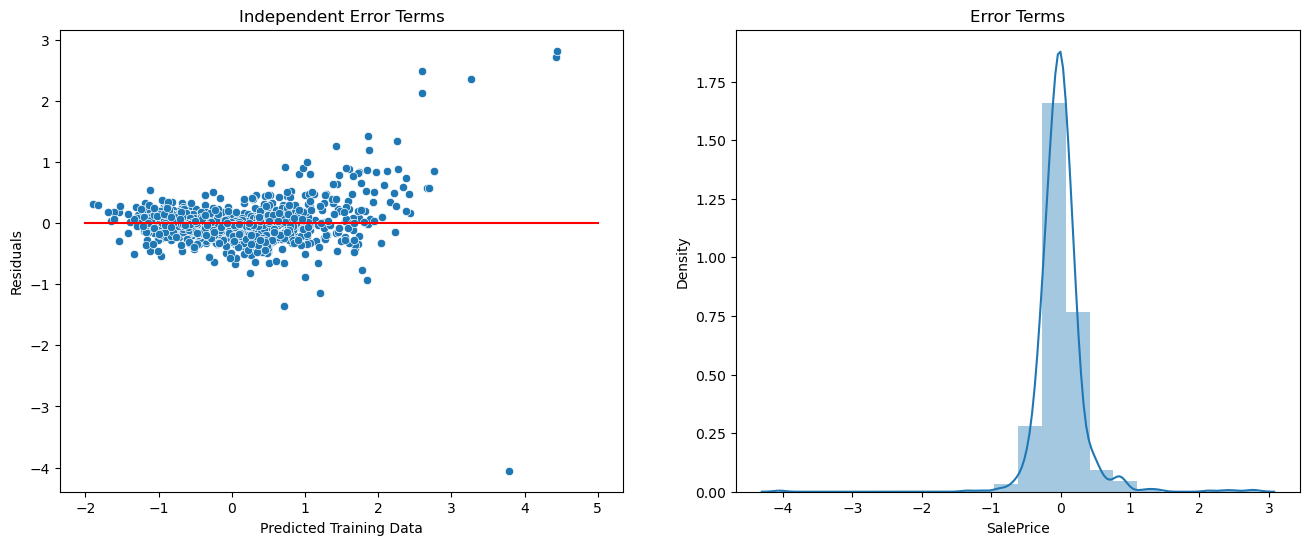

In [56]:
plot_linear_assumptions(y_train, y_pred_train)

### Lasso

###### Performing Grid Search Cross Validation

In [57]:
lasso = Lasso()

model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 82 candidates, totalling 410 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [1e-05, 0.0001, 0.0002, 0.0003, 0.0004,
                                   0.0005, 0.0006, 0.0007, 0.0008, 0.0009,
                                   0.001, 0.01, 0.025, 0.05, 0.075, 0.1, 0.15,
                                   0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55,
                                   0.6, 0.65, 0.7, 0.75, 0.8, ...]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

###### Getting the best alpha

In [58]:
print(model_cv.best_params_)

{'alpha': 0.01}


###### Performing Regression with best alpha

In [59]:
lasso = Lasso(alpha=model_cv.best_params_['alpha'])
        
lasso.fit(X_train, y_train) 

Lasso(alpha=0.01)

In [60]:
print(lasso.coef_)
print(lasso.intercept_)

[-0.00000000e+00  4.77139444e-02  1.86778607e-01  4.50927825e-02
  8.11153847e-03  1.62938136e-02  3.65315757e-02  5.66917025e-02
 -0.00000000e+00  4.39371435e-02 -0.00000000e+00  8.60422939e-02
  1.63582168e-02  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -7.20854397e-03
  3.77256225e-01  4.04994247e-02  0.00000000e+00  2.32157821e-02
  8.34479237e-03 -1.15938865e-02 -4.06924485e-02  5.40544891e-02
  0.00000000e+00  2.91589788e-02 -0.00000000e+00  8.66754818e-02
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  7.26169207e-03
  0.00000000e+00 -1.57498204e-03  4.33855148e-03  9.20858101e-03
 -2.72686938e-02  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00  4.97030541e-02 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -5.60213816e-03 -1.27252099e-03
  0.00000000e+00 -7.60161714e-03 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.61590012e-02 -0.00000

###### Performing Training and Test predictions

In [61]:
y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

###### Metrics Evaluation of Lasso Regression

In [62]:
metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric3.append(mse_test_lr**0.5)

0.8947200387327557
0.8353580847602703
107.4908404538564
74.25893106967888
0.10527996126724427
0.1695409385152486


###### Plotting Linear Assumptions

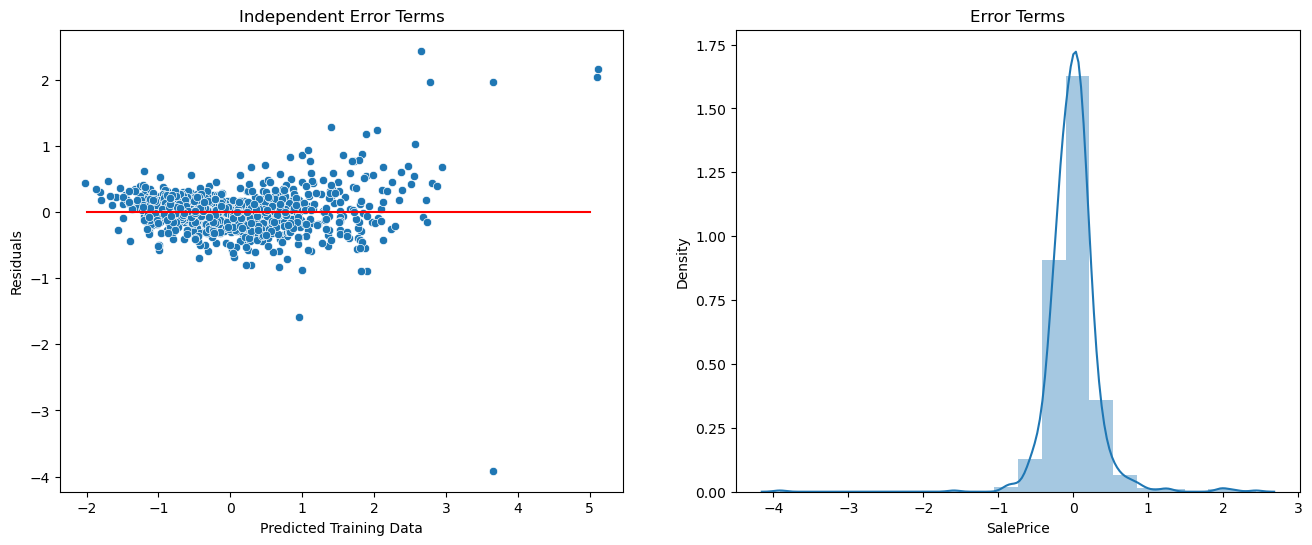

In [63]:
plot_linear_assumptions(y_train, y_pred_train)

#### Comparing the Linear, Ridge and Lasso Regressions

In [64]:
lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)'], 
        'Linear Regression': metric
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )

rg_metric = pd.Series(metric2, name = 'Ridge Regression')
ls_metric = pd.Series(metric3, name = 'Lasso Regression')

final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)

final_metric

Metric  Linear Regression  Ridge Regression  Lasso Regression
0  R2 Score (Train)       9.428975e-01          0.885458          0.894720
1   R2 Score (Test)      -6.239424e+21          0.853050          0.835358
2       RSS (Train)       5.830163e+01        116.947476        107.490840
3        RSS (Test)       2.814186e+24         66.279313         74.258931
4       MSE (Train)       2.389612e-01          0.338441          0.324469
5        MSE (Test)       8.015661e+10          0.389002          0.411753

In [65]:
betas = pd.DataFrame({'columns' : X_train.columns})
betas.rows = X_train.columns
betas['Linear'] = lm.coef_
betas['Ridge'] = ridge.coef_
betas['Lasso'] = lasso.coef_
intercept = pd.DataFrame({'columns' : ['Intercept'], 'Linear' : [lm.intercept_], 'Ridge' : [ridge.intercept_], 'Lasso' : [lasso.intercept_]})
betas = pd.concat([intercept, betas])
betas = betas.set_index('columns')
pd.set_option('display.max_rows', None)
betas

Linear  \
columns                                                            
Intercept                                          -3.101292e-04   
LotFrontage                                         2.997708e-02   
LotArea                                             8.360517e-02   
OverallQual                                         1.342839e-01   
OverallCond                                         8.607378e-02   
YearBuilt                                           7.622195e-02   
YearRemodAdd                                        1.017338e-02   
MasVnrArea                                          4.778598e-02   
ExterQual                                           4.064072e-02   
ExterCond                                          -1.650485e-02   
BsmtQual                                            7.283218e-02   
BsmtCond                                           -3.604584e-02   
BsmtExposure                                        7.861390e-02   
BsmtFinSF1                                          4.033322e+11   
BsmtFinSF2                                          1.482106e+11   
BsmtUnfSF                                           3.892187e+11   
TotalBsmtSF                                        -3.983022e+11   
HeatingQC                                          -5.015731e-03   
1stFlrSF                                           -7.079640e+11   
2ndFlrSF                                           -7.742954e+11   
LowQualFinSF                                       -8.575050e+10   
GrLivArea                                           9.463333e+11   
BsmtFullBath                                        1.660457e-02   
BsmtHalfBath                                       -4.521287e-05   
FullBath                                           -3.732946e-03   
HalfBath                                           -7.551058e-03   
BedroomAbvGr                                       -3.999402e-02   
KitchenAbvGr                                       -4.417805e-02   
KitchenQual                                         3.280697e-02   
TotRmsAbvGrd                                        1.165443e-02   
Fireplaces                                          9.901941e-03   
GarageYrBlt                                         5.133472e-01   
GarageCars                                          3.394700e-02   
GarageArea                                          3.550035e-02   
GarageQual                                          7.705044e-02   
GarageCond                                         -1.154985e-02   
WoodDeckSF                                          7.344677e-03   
OpenPorchSF                                         1.915937e-02   
EnclosedPorch                                      -1.056758e-02   
3SsnPorch                                           1.382214e-02   
ScreenPorch                                         1.245234e-02   
PoolArea                                            3.000167e-02   
MiscVal                                             9.504517e-03   
MoSold                                             -1.332552e-02   
YrSold                                              3.342284e-04   
MSSubClass_1-1-2-STORY-UNFINISHED-ALL-AGES         -5.877103e-03   
MSSubClass_1-STORY-1945-OLDER                       7.956394e-03   
MSSubClass_1-STORY-1946-NEWER-ALL-STYLES           -1.119319e-02   
MSSubClass_1-STORY-PUD-1946-NEWER                  -5.880770e-03   
MSSubClass_1-STORY-W-FINISHED-ATTIC-ALL-AGES        5.660812e-03   
MSSubClass_2-1-2-STORY-ALL-AGES                    -4.047111e-02   
MSSubClass_2-FAMILY-CONVERSION-ALL-STYLES-AND-AGES -1.385607e+11   
MSSubClass_2-STORY-1945-OLDER                       9.807629e-03   
MSSubClass_2-STORY-1946-NEWER                       1.639345e-02   
MSSubClass_2-STORY-PUD-1946-NEWER                   5.614907e-03   
MSSubClass_DUPLEX-ALL-STYLES-AND-AGES               1.530562e+11   
MSSubClass_PUD-MULTILEVEL-INCL-SPLIT-LEV-FOYER     -1.202390e-02   
MSSubClass_SPLIT-FOYER                        

### Conclusions

- **Linear Resgression**: Multiple Linear Regression cannot be selected because of r2 test score.
- **Rigde Regression**: Ridge Regression is able to achieve the least difference between train and test r2 score. However, because of the number of variables, the model becomes more complex.
- **Lasso Regression**: Lasso Regression is the model of choice here. The r2 score is good and difference between training and test r2 score is accdeptable. The model is simpler because of fewer variables (excluding the ones the Lasso to which Lasso assigned a 0 co-efficient score).

**Lasso Regression** is the model selected model.